In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 320

ng =12

ng_adju = (/ 0 , 0 /) 

ng_refs = (/ 3 , 3 , 6 /) 

nref =3

nv = 1000

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 20

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.5 , 1.5 , 1.5 , 1.5/

data wgt
     &     /0.2 , 0.2 , 0.2 , 0.2,
     &     0.2 , 0.2 , 0.2 , 0.2,
     &     0.65 , 0.65 , 0.65 , 0.65/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

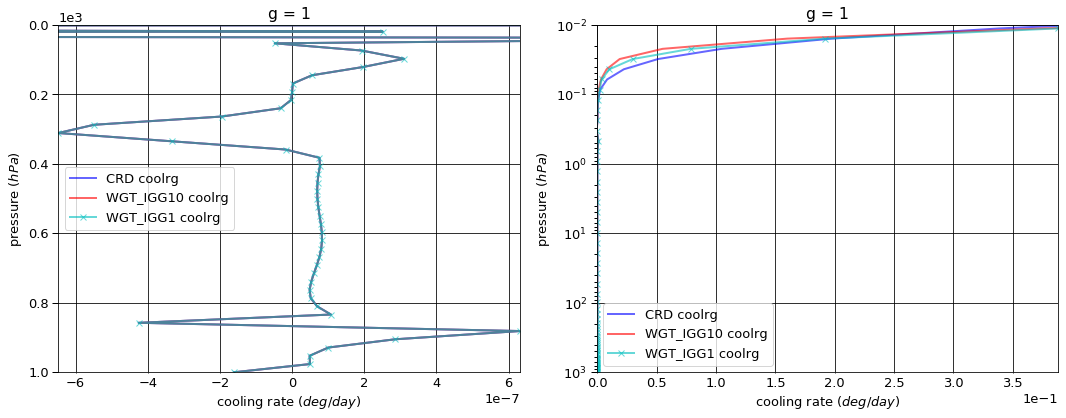

# Figure: cooling rate g-group 2

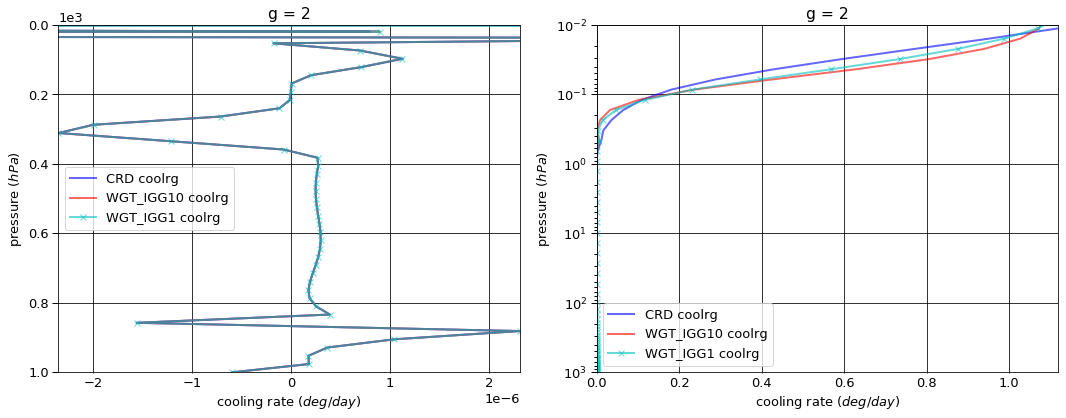

# Figure: cooling rate g-group 3

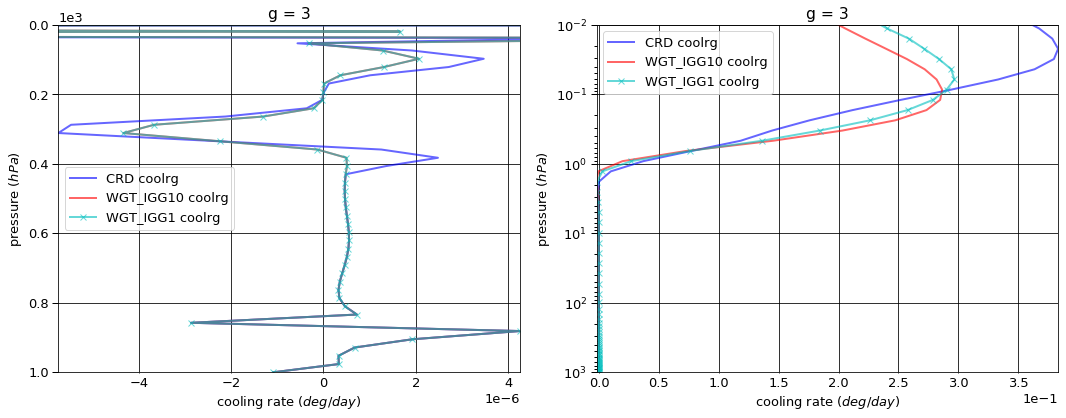

# Figure: cooling rate g-group 4

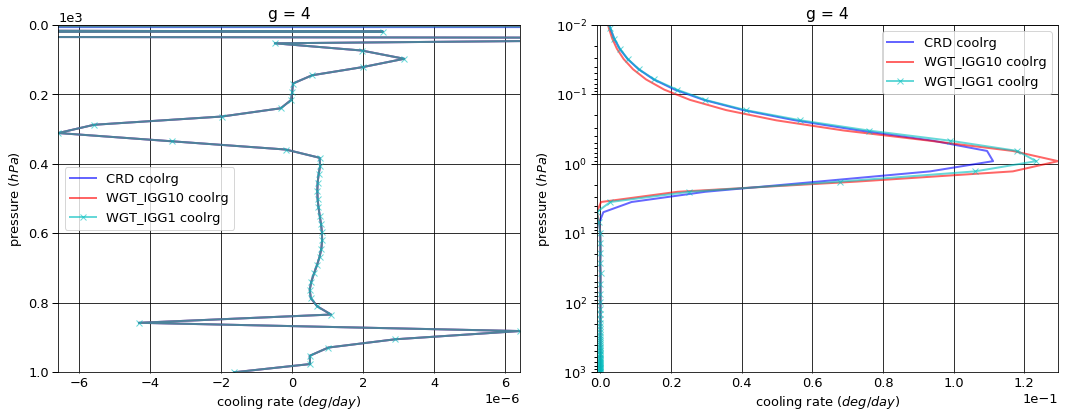

# Figure: cooling rate g-group 5

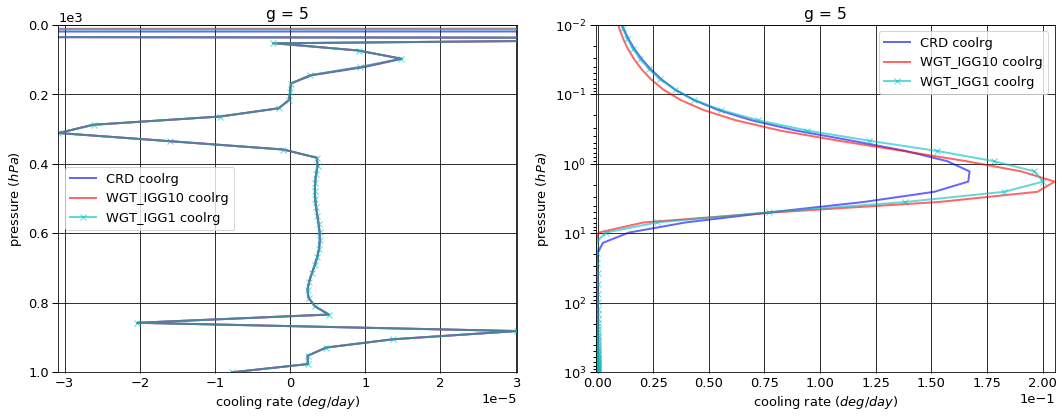

# Figure: cooling rate g-group 6

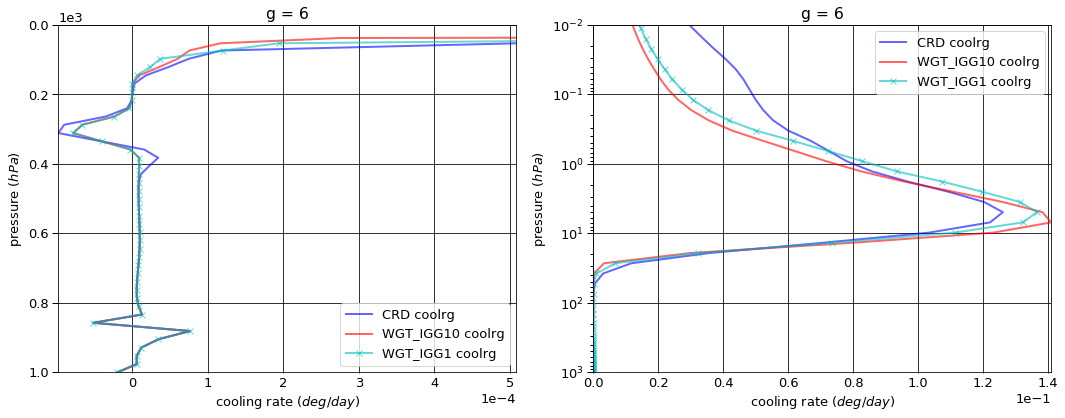

# Figure: cooling rate g-group 7

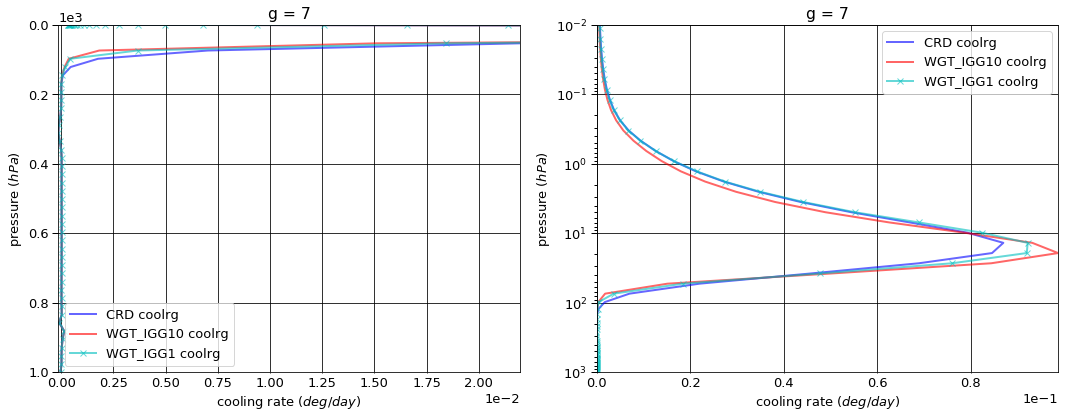

# Figure: cooling rate g-group 8

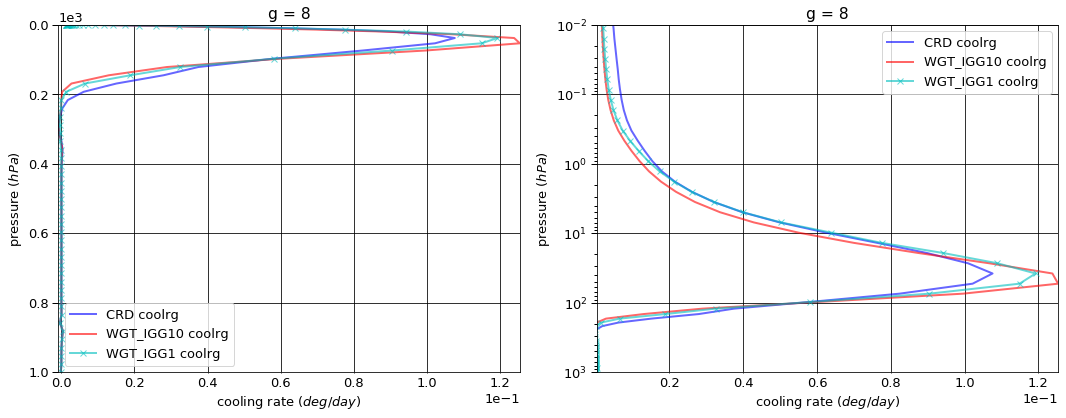

# Figure: cooling rate g-group 9

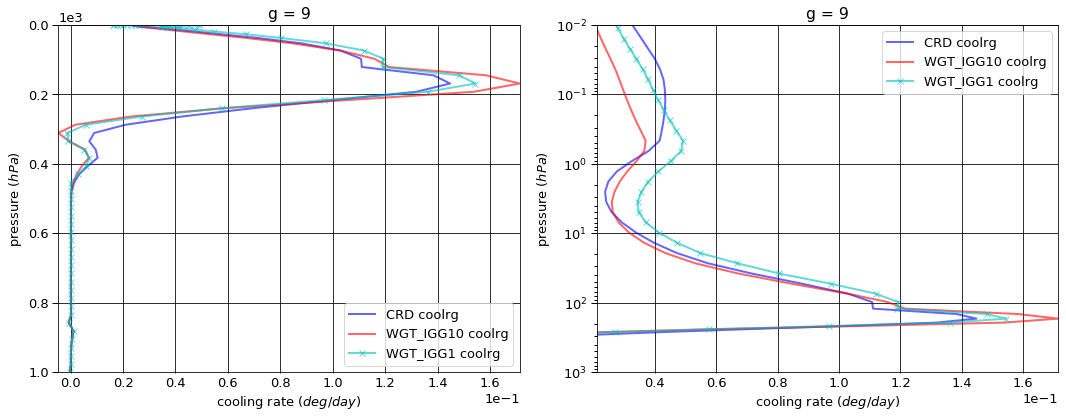

# Figure: cooling rate g-group 10

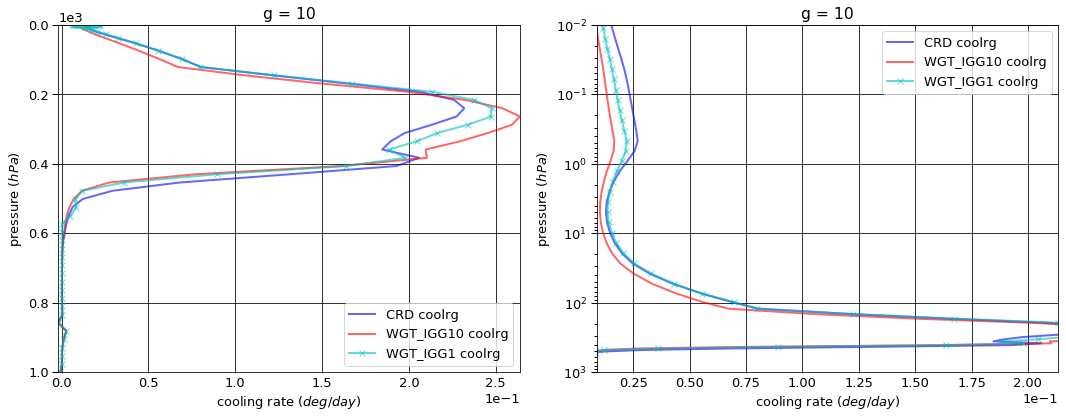

# Figure: cooling rate g-group 11

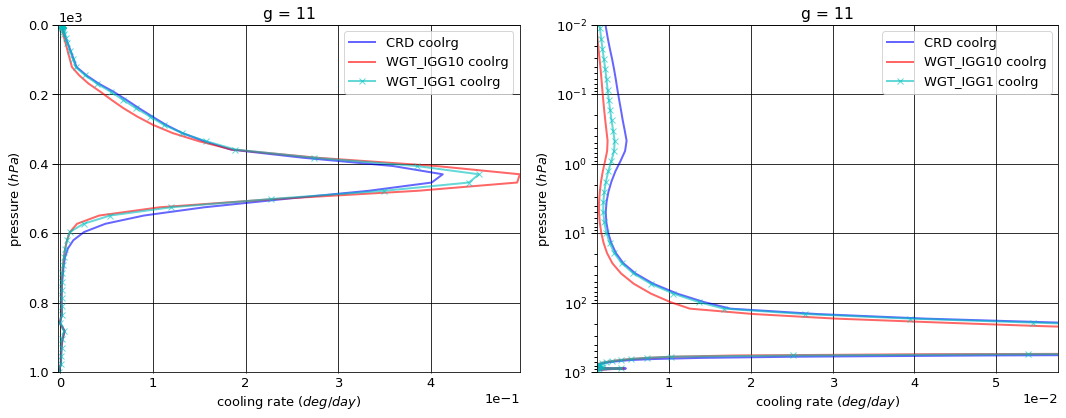

# Figure: cooling rate g-group 12

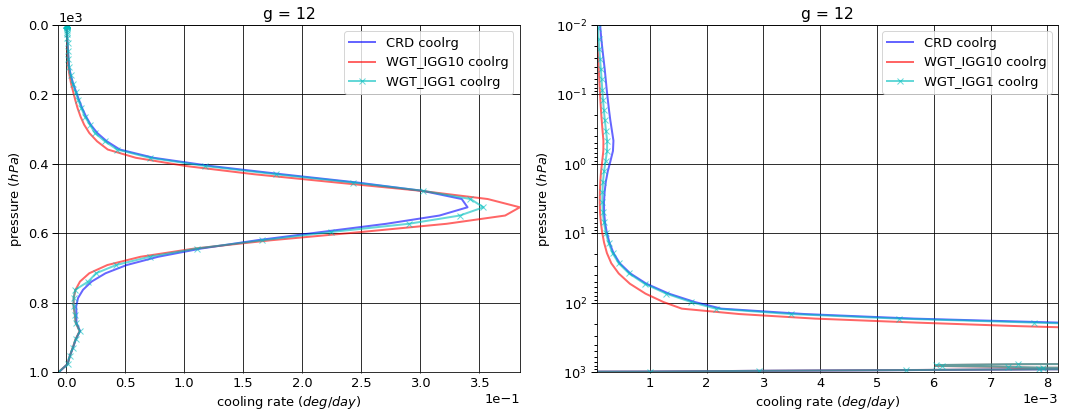

# Figure: cooling rate g-group total

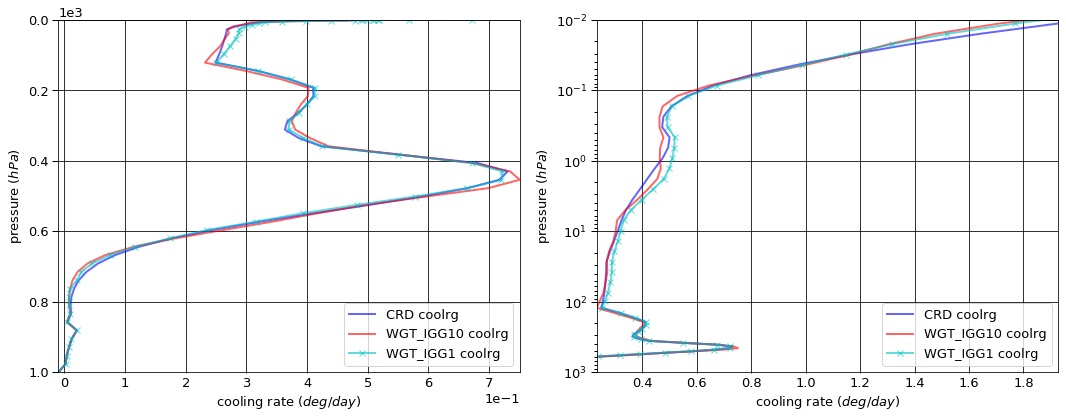

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg         fnetg
g  pressure level                                    
1  0.0      1      -0.002003   0.000000 -2.003148e-03
   1013.0   76     -0.002554   0.002555  5.548311e-07
2  0.0      1      -0.007771   0.000000 -7.770708e-03
   1013.0   76     -0.008832   0.008834  2.032282e-06
3  0.0      1      -0.015896   0.000000 -1.589597e-02
   1013.0   76     -0.016596   0.016599  3.740420e-06
4  0.0      1      -0.024041   0.000000 -2.404111e-02
   1013.0   76     -0.026050   0.026055  5.641294e-06
5  0.0      1      -0.099323   0.000000 -9.932315e-02
   1013.0   76     -0.119150   0.119177  2.655471e-05
6  0.0      1      -0.230915   0.000000 -2.309147e-01
   1013.0   76     -0.303506   0.303573  6.728263e-05
7  0.0      1      -0.401051   0.000000 -4.010507e-01
   1013.0   76     -0.550255   0.550377  1.213195e-04
8  0.0      1      -1.297616   0.000000 -1.297616e+00
   1013.0   76     -1.773768   1.774158  3.905594e-04
9  0.0      1      -3.332872   0.000000 -3.332872e+00
   1013.0   76     -4.506658   4.507653  9.946800e-04
10 0.0      1      -8.172957   0.000000 -8.172957e+00
   1013.0   76    -10.785854  10.788305  2.451627e-03
11 0.0      1      -9.578234   0.000000 -9.578234e+00
   1013.0   76    -11.914127  11.921694  7.567071e-03
12 0.0      1      -8.782479   0.000000 -8.782479e+00
   1013.0   76    -10.254119  10.284049  2.992988e-02


WGT_IGG10


flug       fldg         fnetg
g  pressure level                                    
1  0.0      1      -0.002002   0.000000 -2.001913e-03
   1013.0   76     -0.002554   0.002555  5.548311e-07
2  0.0      1      -0.007813   0.000000 -7.812922e-03
   1013.0   76     -0.008832   0.008834  2.032282e-06
3  0.0      1      -0.016104   0.000000 -1.610432e-02
   1013.0   76     -0.016596   0.016599  3.740420e-06
4  0.0      1      -0.024330   0.000000 -2.433027e-02
   1013.0   76     -0.026050   0.026055  5.641294e-06
5  0.0      1      -0.100751   0.000000 -1.007514e-01
   1013.0   76     -0.119150   0.119177  2.655471e-05
6  0.0      1      -0.231319   0.000000 -2.313186e-01
   1013.0   76     -0.303506   0.303573  6.728263e-05
7  0.0      1      -0.399969   0.000000 -3.999693e-01
   1013.0   76     -0.550255   0.550377  1.213195e-04
8  0.0      1      -1.294249   0.000000 -1.294249e+00
   1013.0   76     -1.773768   1.774158  3.905594e-04
9  0.0      1      -3.330328   0.000000 -3.330328e+00
   1013.0   76     -4.506658   4.507653  9.946800e-04
10 0.0      1      -8.125591   0.000000 -8.125591e+00
   1013.0   76    -10.785854  10.788264  2.410569e-03
11 0.0      1      -9.569263   0.000000 -9.569263e+00
   1013.0   76    -11.914127  11.920810  6.683066e-03
12 0.0      1      -8.821559   0.000000 -8.821559e+00
   1013.0   76    -10.254119  10.283420  2.930173e-02


WGT_IGG1


flug       fldg         fnetg
g  pressure level                                    
1  0.0      1      -0.002005   0.000000 -2.005484e-03
   1013.0   76     -0.002554   0.002555  5.548311e-07
2  0.0      1      -0.007810   0.000000 -7.810454e-03
   1013.0   76     -0.008832   0.008834  2.032282e-06
3  0.0      1      -0.016060   0.000000 -1.605991e-02
   1013.0   76     -0.016596   0.016599  3.740420e-06
4  0.0      1      -0.024281   0.000000 -2.428099e-02
   1013.0   76     -0.026050   0.026055  5.641294e-06
5  0.0      1      -0.100757   0.000000 -1.007571e-01
   1013.0   76     -0.119150   0.119177  2.655471e-05
6  0.0      1      -0.231707   0.000000 -2.317066e-01
   1013.0   76     -0.303506   0.303573  6.728263e-05
7  0.0      1      -0.400745   0.000000 -4.007447e-01
   1013.0   76     -0.550255   0.550377  1.213195e-04
8  0.0      1      -1.295310   0.000000 -1.295310e+00
   1013.0   76     -1.773768   1.774158  3.905594e-04
9  0.0      1      -3.328550   0.000000 -3.328550e+00
   1013.0   76     -4.506658   4.507653  9.946800e-04
10 0.0      1      -8.124730   0.000000 -8.124730e+00
   1013.0   76    -10.785854  10.788264  2.410569e-03
11 0.0      1      -9.528576   0.000000 -9.528576e+00
   1013.0   76    -11.914127  11.920769  6.642396e-03
12 0.0      1      -8.776237   0.000000 -8.776237e+00
   1013.0   76    -10.254119  10.284049  2.993062e-02


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      1.234500e-06  0.000000e+00  1.234500e-06
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2  0.0      1     -4.221490e-05  0.000000e+00 -4.221490e-05
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3  0.0      1     -2.083490e-04  0.000000e+00 -2.083490e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1     -2.891600e-04  0.000000e+00 -2.891600e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5  0.0      1     -1.428280e-03  0.000000e+00 -1.428280e-03
   1013.0   76     0.000000e+00 -1.387779e-17  0.000000e+00
6  0.0      1     -4.039600e-04  0.000000e+00 -4.039600e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      1.081340e-03  0.000000e+00  1.081340e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      3.366600e-03  0.000000e+00  3.366600e-03
   1013.0   76     0.000000e+00  0.000000e+00 -5.421011e-20
9  0.0      1      2.544000e-03  0.000000e+00  2.544000e-03
   1013.0   76     0.000000e+00  0.000000e+00  2.168404e-19
10 0.0      1      4.736600e-02  0.000000e+00  4.736600e-02
   1013.0   76    -1.776357e-15 -4.100000e-05 -4.105730e-05
11 0.0      1      8.971400e-03  0.000000e+00  8.971400e-03
   1013.0   76     0.000000e+00 -8.840000e-04 -8.840049e-04
12 0.0      1     -3.908020e-02  0.000000e+00 -3.908020e-02
   1013.0   76     1.776357e-15 -6.290000e-04 -6.281570e-04


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1     -2.336700e-06  0.000000e+00 -2.336700e-06
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2  0.0      1     -3.974680e-05  0.000000e+00 -3.974680e-05
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3  0.0      1     -1.639420e-04  0.000000e+00 -1.639420e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1     -2.398720e-04  0.000000e+00 -2.398720e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5  0.0      1     -1.433980e-03  0.000000e+00 -1.433980e-03
   1013.0   76     0.000000e+00 -1.387779e-17  0.000000e+00
6  0.0      1     -7.919100e-04  0.000000e+00 -7.919100e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      3.059800e-04  0.000000e+00  3.059800e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      2.305800e-03  0.000000e+00  2.305800e-03
   1013.0   76     0.000000e+00  0.000000e+00 -5.421011e-20
9  0.0      1      4.322400e-03  0.000000e+00  4.322400e-03
   1013.0   76     0.000000e+00  0.000000e+00  2.168404e-19
10 0.0      1      4.822750e-02  0.000000e+00  4.822750e-02
   1013.0   76    -1.776357e-15 -4.100000e-05 -4.105730e-05
11 0.0      1      4.965800e-02  0.000000e+00  4.965800e-02
   1013.0   76     0.000000e+00 -9.250000e-04 -9.246746e-04
12 0.0      1      6.242500e-03  0.000000e+00  6.242500e-03
   1013.0   76     1.776357e-15 -1.776357e-15  7.370000e-07

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      4.374910e+00
   1001.112500 75    -1.611260e-07
2  0.000312    1      1.415496e+00
   1001.112500 75    -5.902550e-07
3  0.000312    1      1.916169e-01
   1001.112500 75    -1.086338e-06
4  0.000312    1      1.550880e-04
   1001.112500 75    -1.638246e-06
5  0.000312    1      2.661278e-03
   1001.112500 75    -7.712125e-06
6  0.000312    1      1.145779e-02
   1001.112500 75    -1.954032e-05
7  0.000312    1      3.221858e-04
   1001.112500 75    -3.523304e-05
8  0.000312    1      3.120499e-03
   1001.112500 75    -1.134258e-04
9  0.000312    1      1.788383e-02
   1001.112500 75    -2.888740e-04
10 0.000312    1      7.909774e-03
   1001.112500 75    -7.106428e-04
11 0.000312    1      1.061094e-03
   1001.112500 75    -2.147683e-03
12 0.000312    1      4.786738e-05
   1001.112500 75    -6.533518e-03


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      2.742697e+00
   1001.112500 75    -1.611260e-07
2  0.000312    1      7.358197e-01
   1001.112500 75    -5.902550e-07
3  0.000312    1      9.280025e-02
   1001.112500 75    -1.086338e-06
4  0.000312    1      1.707401e-04
   1001.112500 75    -1.638246e-06
5  0.000312    1      2.925410e-03
   1001.112500 75    -7.712125e-06
6  0.000312    1      5.821994e-03
   1001.112500 75    -1.954032e-05
7  0.000312    1      2.627435e-04
   1001.112500 75    -3.523304e-05
8  0.000312    1      1.062755e-03
   1001.112500 75    -1.134258e-04
9  0.000312    1      1.202307e-02
   1001.112500 75    -2.888740e-04
10 0.000312    1      4.672538e-03
   1001.112500 75    -7.000865e-04
11 0.000312    1      5.313821e-04
   1001.112500 75    -1.926707e-03
12 0.000312    1      2.296086e-05
   1001.112500 75    -6.888142e-03


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      3.078949e+00
   1001.112500 75    -1.611260e-07
2  0.000312    1      9.044311e-01
   1001.112500 75    -5.902550e-07
3  0.000312    1      1.153492e-01
   1001.112500 75    -1.086338e-06
4  0.000312    1      1.995227e-04
   1001.112500 75    -1.638246e-06
5  0.000312    1      3.352540e-03
   1001.112500 75    -7.712125e-06
6  0.000312    1      6.738480e-03
   1001.112500 75    -1.954032e-05
7  0.000312    1      3.104099e-04
   1001.112500 75    -3.523304e-05
8  0.000312    1      1.271635e-03
   1001.112500 75    -1.134258e-04
9  0.000312    1      1.599576e-02
   1001.112500 75    -2.888740e-04
10 0.000312    1      6.257868e-03
   1001.112500 75    -7.000865e-04
11 0.000312    1      7.297705e-04
   1001.112500 75    -1.823905e-03
12 0.000312    1      3.232702e-05
   1001.112500 75    -6.834438e-03


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.632213e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -6.796762e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -9.881663e-02
   1001.112500 75     0.000000e+00
4  0.000312    1      1.565211e-05
   1001.112500 75     0.000000e+00
5  0.000312    1      2.641317e-04
   1001.112500 75     0.000000e+00
6  0.000312    1     -5.635797e-03
   1001.112500 75    -3.388132e-21
7  0.000312    1     -5.944230e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -2.057744e-03
   1001.112500 75     0.000000e+00
9  0.000312    1     -5.860758e-03
   1001.112500 75     0.000000e+00
10 0.000312    1     -3.237235e-03
   1001.112500 75     1.055626e-05
11 0.000312    1     -5.297116e-04
   1001.112500 75     2.209752e-04
12 0.000312    1     -2.490652e-05
   1001.112500 75    -3.546235e-04


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.295961e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -5.110648e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -7.626766e-02
   1001.112500 75     0.000000e+00
4  0.000312    1      4.443477e-05
   1001.112500 75     0.000000e+00
5  0.000312    1      6.912617e-04
   1001.112500 75     0.000000e+00
6  0.000312    1     -4.719311e-03
   1001.112500 75    -3.388132e-21
7  0.000312    1     -1.177586e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.848864e-03
   1001.112500 75     0.000000e+00
9  0.000312    1     -1.888070e-03
   1001.112500 75     0.000000e+00
10 0.000312    1     -1.651906e-03
   1001.112500 75     1.055626e-05
11 0.000312    1     -3.313232e-04
   1001.112500 75     3.237772e-04
12 0.000312    1     -1.554035e-05
   1001.112500 75    -3.009202e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.945158,0.000000,-31.945158
1013.0,76,-40.261469,40.303029,0.041561



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.923280,0.000000,-31.923280
1013.0,76,-40.261469,40.301475,0.040008



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.836768,0.000000,-31.836768
1013.0,76,-40.261469,40.302063,0.040596



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.187841e-02,0.000000,0.021878
1013.0,76,7.105427e-15,-0.001554,-0.001553



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.083904e-01,0.000000,0.108390
1013.0,76,7.105427e-15,-0.000966,-0.000965


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,6.026642
1001.112500,75,-0.009860



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,3.598811
1001.112500,75,-0.009983



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,4.133617
1001.112500,75,-0.009827



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.427831
1001.112500,75,-0.000123



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.893025
1001.112500,75,0.000033


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000072,0.000064
2,0.000222,0.000220
3,0.000466,0.000413
4,0.000716,0.000650
5,0.003416,0.002969
6,0.008944,0.007564
7,0.015216,0.013716
8,0.054069,0.044218
9,0.134259,0.112332


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.008873e-16
2,7.670263e-17
3,1.174574e-17
4,2.908125e-17
5,4.811102e-18
6,7.959323e-19
7,1.130903e-18
8,1.928796e-19
9,3.289633e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.008873e-16,NaN,0.000072,0.000064,0.000072,0.000064,1.0
2,7.670263e-17,0.153134,0.000222,0.000220,0.000294,0.000283,1.0
3,1.174574e-17,0.153134,0.000466,0.000413,0.000759,0.000697,1.0
4,2.908125e-17,2.475897,0.000716,0.000650,0.001475,0.001347,30.0
5,4.811102e-18,0.165437,0.003416,0.002969,0.004891,0.004315,30.0
6,7.959323e-19,0.165437,0.008944,0.007564,0.013834,0.011879,30.0
7,1.130903e-18,1.420853,0.015216,0.013716,0.029050,0.025595,300.0
8,1.928796e-19,0.170554,0.054069,0.044218,0.083119,0.069813,300.0
9,3.289633e-20,0.170554,0.134259,0.112332,0.217378,0.182145,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
